In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.1 MB/s eta 0:00:00


In [3]:
import os

from ultralytics import YOLO
import cv2
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime
from sklearn.cluster import KMeans
from skimage.feature import canny

import pickle
from torchvision import models, transforms
import torch
import torch.nn as nn

DETECT LOGO FROM THE IMAGE

In [4]:
model_path = ('/content/drive/MyDrive/yolo/runs/detect/train/weights/last.pt')

# Load a model
model = YOLO(model_path)  # load a custom model

threshold = 0.5
def pred(img_path):
  frame = Image.open(img_path)

  frame1 = np.asarray(frame)
  results = model(frame1)[0]
  # img1 = ImageDraw.Draw(frame)

  for result in results.boxes.data.tolist():
    row = []
    column = []
    x1, y1, x2, y2, score, class_id = result

    if score > threshold:
        cv2.rectangle(frame1, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 4)
        cv2.putText(frame1, results.names[int(class_id)].upper() + ": " + str(round(score, 2)), (int(x1), int(y1 - 10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3, cv2.LINE_AA)
        row.append(int(x1))
        row.append(int(x2))
        column.append(int(y1))
        column.append(int(y2))

  plt.imshow(frame1)
  return row, column

def crop_save(img_path,row,end_column):
  img = Image.open(img_path)
  img = img.crop((row[0],column[0],row[1],column[1]))
  img.save('crop.jpg')


0: 384x640 1 logo, 164.4ms
Speed: 18.9ms preprocess, 164.4ms inference, 41.1ms postprocess per image at shape (1, 3, 384, 640)


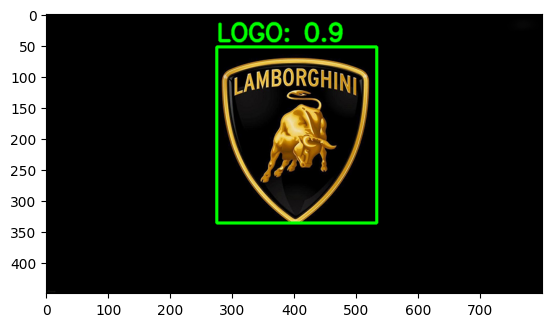

In [5]:
#Detect logo in the image
row, column = pred("/content/lamborghini.jpg")
#Crop logo detected and save as file
crop_save("/content/lamborghini.jpg",row,column)

EXTRACT FEATURES DATASET

In [6]:
def canny_filter(img):
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  edge = canny(gray)
  edge = edge.astype(np.int16)
  edge = np.repeat(edge[..., np.newaxis], 3, -1)
  return edge

class FeatureExtractor:
    def __init__(self):
        # Use MobileNet V2 as the architecture and ImageNet for the weight
        self.model = models.mobilenet_v3_small(pretrained=True)
        # Remove the last layer (output layer)
        self.model.classifier = nn.Sequential(*list(self.model.classifier.children())[:-1])
        self.model.eval()
        # Define image transforms
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    def extract(self, img):
        # Convert the image color space
        img = cv2.imread(img)
        img = canny_filter(img)
        # Apply image transforms
        img = torch.FloatTensor(img).permute(2, 1, 0).unsqueeze(0)
        # Add batch dimension
        # Extract Features
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        net = self.model.to(device)
        img = img.to(device)
        with torch.no_grad():
            feature = net(img).flatten()
            feature = feature.to('cpu')
            feature = feature.numpy()
        img = img.detach()
        torch.cuda.empty_cache()
        return feature / np.linalg.norm(feature)

In [7]:
extract_feat = FeatureExtractor()
def ReadData(path):
  features_dict = {}
  for sector in os.listdir(path):
    path_sector = os.path.join(path, sector)
    # if os.path.exists('/content/drive/MyDrive/features/'+ sector + '.pkl') is False:
    tmp = tqdm(os.listdir(path_sector))
    for brand in tmp:
      path_brand = os.path.join(path_sector, brand)
      tmp.set_description(path_brand)
      for filename in os.listdir(path_brand):
        direct = os.path.join(path_brand, filename)
        feature = extract_feat.extract(direct)
        features_dict[direct] = feature
      # with open('drive/MyDrive/features/'+ sector + '.pkl',"wb") as file:
      #   pickle.dump(features_dict,file)

  return features_dict

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 65.5MB/s]


In [20]:
path = ("/content/drive/MyDrive/dataset/datasetcopy/trainandtest/train")
features = ReadData(path)

/content/drive/MyDrive/dataset/datasetcopy/trainandtest/train/Clothes/Msting:  68%|██████▊   | 194/286 [2:47:01<1:19:12, 51.66s/it]


KeyboardInterrupt: ignored

KMEANS TO CLUSTERING

In [61]:
#Cluster the features
n_clusters=5
kmeans = KMeans(n_clusters = n_clusters, random_state=0)
kmeans.fit(list(features.values()))
labels = kmeans.labels_
centers = kmeans.cluster_centers_
label = {}
label["features"] = features
label["label"] = labels
label["centers"] = centers

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
#Load vector features labeled by KMeans to search
if os.path.exists('drive/MyDrive/Project/new_clusters.pkl') is True:
  with open("drive/MyDrive/Project/new_clusters.pkl","rb") as file:
    label = pickle.load(file)
else:
#Save first time running system not have file .pkl
  with open("drive/MyDrive/Project/new_clusters.pkl","wb") as file:
    pickle.dump(label,file)

RETRIEVAL THE LOGO IMAGE AFTER DETECTED

In [62]:
input_dir = "/content/crop.jpg"
top_k = 20

input_fea = extract_feat.extract(input_dir)
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
#Predict the label of input
max = 0
for x in range(len(label["centers"])):
  output = cos(torch.Tensor(label["centers"][x]), torch.Tensor(input_fea))
  output = float(output)
  if output > max:
    predict_label = x
    max = output
#Take all path in label to compare
indices = [i for i, x in enumerate(label["label"]) if x == predict_label]
feature_key = list(label["features"].keys())
result = {}
for i in indices:
  vector_fea = label["features"][feature_key[i]]
  output = cos(torch.Tensor(vector_fea), torch.Tensor(input_fea))
  output = output.detach() #for gpu
  result[feature_key[i]] = float(output)

#Sort similarity and take k_top
result = dict(sorted(result.items(), key=lambda item: item[1], reverse = True))
result = {list(result.keys())[x]: list(result.values())[x] for x in range(top_k)}

#Save result image and print the similarity:
if os.path.isdir('drive/MyDrive/Result_Img') is True and len(os.listdir('drive/MyDrive/Result_Img')) != 0:
  for filename in os.listdir("drive/MyDrive/Result_Img"):
    file = os.path.join("drive/MyDrive/Result_Img", filename)
    os.remove(file)
elif(os.path.isdir('drive/MyDrive/Result_Img') is False):
  os.mkdir('drive/MyDrive/Result_Img')
for x in result:
  print(x+": ", result[x])
  img = Image.open(x)
  tmp = x.split('/')[-2] + '_' + x.split('/')[-1]
  res_path = 'drive/MyDrive/Result_Img/' + tmp
  img.save(res_path)

/content/drive/MyDrive/dataset/datasetcopy/trainandtest/train/Transportation/Puch/75.jpg:  0.8881374597549438
/content/drive/MyDrive/dataset/datasetcopy/trainandtest/train/Transportation/Lamborghini/26.jpg:  0.8853529095649719
/content/drive/MyDrive/dataset/datasetcopy/trainandtest/train/Transportation/Lamborghini/32.jpg:  0.869438886642456
drive/MyDrive/dataset/datasetcopy/trainandtest/train/Leisure/Burtons/42.jpg:  0.8400683403015137
drive/MyDrive/dataset/datasetcopy/trainandtest/train/Leisure/Burtons/55.jpg:  0.8400683403015137
/content/drive/MyDrive/dataset/datasetcopy/trainandtest/train/Transportation/Ducati/8.jpg:  0.8362550139427185
/content/drive/MyDrive/dataset/datasetcopy/trainandtest/train/Necessities/Crayola/41.jpg:  0.8358809947967529
/content/drive/MyDrive/dataset/datasetcopy/trainandtest/train/Transportation/Dacia/39.jpg:  0.8349721431732178
/content/drive/MyDrive/dataset/datasetcopy/trainandtest/train/Transportation/Dacia/3.jpg:  0.8334222435951233
/content/drive/MyDriv